In [225]:
%reset #clear the ipython workspace variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #clear, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  ipython, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy import array
from scipy.optimize import curve_fit

# Change Data Access Location For Google Drive



In [227]:
#data is on google drive so need to load
from google.colab import drive
drive.mount('/content/drive')
#this line needs to be changed depending on file structure of google drive
os.chdir('/content/drive/MyDrive/WVU_GradStudents_ShareFolder/Jacob_Research/New LSTM Crack')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Inputs

In [228]:
# Use the datapoint every (interval) point
interval = 1000
# How Many datapoints around the selected to use
# For 0, Just uses the data in front
# For others, Uses (avg) in front and behind
avg = 50
# Desired Temperature to generate data for
desired_temp = 773
# Desired Force to generate data for
force = 1800
# Add Noise? 0=no 1=yes
add_noise = 1

                Time  Crack Length  Force    Temp
0         175.976561      0.363964   1800  308.15
1         176.171871      0.351573   1800  308.15
2         176.367191      0.319016   1800  308.15
3         176.562501      0.313823   1800  308.15
4         176.757811      0.302488   1800  308.15
...              ...           ...    ...     ...
178568  48768.165891      1.874069   1800  308.15
178569  48768.360891      1.812874   1800  308.15
178570  48768.556891      1.831840   1800  308.15
178571  48768.751891      1.855713   1800  308.15
178572  48768.946891      1.866016   1800  308.15

[178573 rows x 4 columns]
[  175.9765659   176.1718759   176.3671859 ... 33579.4913359 33579.6863359
 33579.8823359]
(178573, 4)


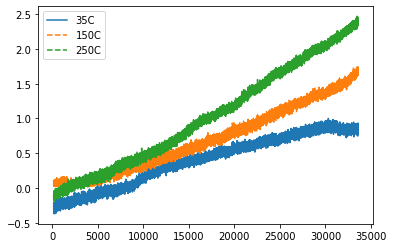

In [229]:
T1_timeoffset = 0
T1_crackoffset = 0.0
T2_timeoffset = 0
T2_crackoffset = 0.0
T3_timeoffset = 0
T3_crackoffset = 0.0

if force==1600:
  T1 = './Test/HeatTreated/t35_4-3-21_R05_1600N_testing.csv'
  T2 = './Test/HeatTreated/t150_4-15-21_R05_1600N_testing.csv'
  T2_timeoffset = 0
  T2_crackoffset = -0.4
  T3 = './Test/HeatTreated/t250_4-8-21_R05_1600N_testing.csv'
elif force == 1700:
  T1 = './Test/HeatTreated/t35_4-2-21_R05_1700N_testing.csv'
  T2 = './Test/HeatTreated/t150_4-13-21_R05_1700N_testing.csv'
  T3 = './Test/HeatTreated/t250_4-7-21_R05_1700N_testing.csv'
else:
  T1 = './Test/HeatTreated/t35_4-19-21_R05_1800N_testing.csv'
  T1_timeoffset = 0
  T1_crackoffset = -0.6
  T2 = './Test/HeatTreated/t150_4-12-21_R05_1800N_testing.csv'
  T3 = './Test/HeatTreated/t250_4-21-21_R05_1800N_testing.csv'
  T3_timeoffset = 0
  T3_crackoffset = -0.4
#
#
T1_df = pd.read_csv(T1)
T1_arr = np.array(T1_df)
T2_df = pd.read_csv(T2)
T2_arr = np.array(T2_df)
T3_df = pd.read_csv(T3)
T3_arr = np.array(T3_df)

print(T1_df)

#Adjust the Size of the arrays to take into consideration the need for same
#length vector operations. Set to min length
#
# column1 = time, column2 = crack length, column3 = force, column4 = temperature
min_size = min(len(T1_arr),len(T2_arr),len(T3_arr))
T1_x = T1_arr[:min_size,0]+T1_timeoffset #time
T1_y = T1_arr[:min_size,1]+T1_crackoffset #crack length

T2_x = T2_arr[:min_size,0]+T2_timeoffset #we need to check initial crack lengths
T2_y = T2_arr[:min_size,1]+T2_crackoffset #we need to check initial crack lengths

T3_x = T3_arr[:min_size,0]+T3_timeoffset
T3_y = T3_arr[:min_size,1]+T3_crackoffset
print(T2_x)

print(T1_arr.shape)

#plot data to compare reshape
fig, (ax) = plt.subplots(1,1)
ax.plot(T1_x,T1_y, '-', label='35C') # 
ax.plot(T2_x,T2_y, '--', label='150C')
ax.plot(T3_x,T3_y, '--', label='250C')
ax.legend()
plt.show()

# Fit Data to 2-D polynomial

Create Temperature inputs for given number of points

In [230]:
i = 0
X = []
while i < len(T1_x):
  # Temperatures to use are defined below, Should Correspond to
  # Data in use
  X_timestep = [[308.15/700],[433.15/700],[523.15/700]] #normalize the temperature
  X.append(X_timestep)
  i += 1

# Array of temperatures
# Takes form
# [[T1]
#  [T2]
#  [T3]]
x = np.asarray(X)

Create's Time inputs for given number of points

In [231]:
max_time = np.amax([T1_x,T2_x,T3_x]) #time
y = np.column_stack((T1_x,T2_x,T3_x)) #horizontal stack data
print(y)

[[  175.9765606   175.9765659   175.9765644]
 [  176.1718706   176.1718759   176.1718744]
 [  176.3671906   176.3671859   176.3671844]
 ...
 [33579.2988906 33579.4913359 33579.4899844]
 [33579.4938906 33579.6863359 33579.6859844]
 [33579.6898906 33579.8823359 33579.8809844]]


Create the Vector of Crack Lengths to fit the curve to

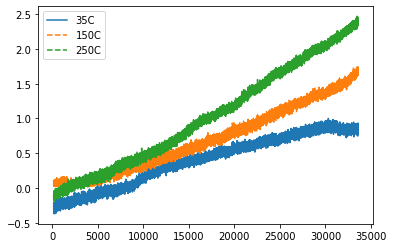

In [232]:
#max_crack = np.amax([T1_y,T2_y,T3_y])
Z = np.column_stack((T1_y,T2_y,T3_y)) #horizontal stack data

#plot data to compare reshape
fig, (ax) = plt.subplots(1,1)
ax.plot(y[:,0],Z[:,0], '-', label='35C') # 
ax.plot(y[:,1],Z[:,1], '--', label='150C')
ax.plot(y[:,2],Z[:,2], '--', label='250C')
ax.legend()
plt.show()

Generate coefficients for the polynomials

In [233]:
coeff_mtx = []
X = x.flatten() #temperature
Y = y.flatten() #time

# 2D polynomial X,Y values for previous Timesteps and Temperatures
# we want to force the z-intercept to be zero at Y=0
#A = np.array([X*Y*0, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
A = np.array([X*Y*0, X, Y, X**2, X**2*Y, X**2*Y**2, (Y**2)*0, (X*Y**2)*0, X*Y*0]).T
# Target Values
B = Z.flatten()

# Z=A*B
# Fit Curve
coeff, r, rank, s = np.linalg.lstsq(A, B)
# Generate Coeff matrix and save for later
coeff_mtx.append(coeff)
coeff_mtx = np.asarray(coeff_mtx)
print(coeff_mtx)

[[ 0.00000000e+00 -6.79625929e-01  1.44203606e-05  7.45043767e-01
   6.99000716e-05  1.01697538e-09  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


# Generate New Data

Generate time and temperature Vectors

In [234]:
def create_times(tlen):
  times = []
  t=0
  times.append(t)
  for i in range(1,max_len):
    if (i%512==0):
      t=t+39.45312999999999
      times.append(t)
    else:
      t=t+0.19531
      times.append(t)
  return np.array(times)

In [235]:
# Generate data for number of points equal to the smallest amount of data read in
# we need to do some complicated shit here because there is a change in timestep every 512 steps.
# don't have time to fix this but we should resamples data. 
max_len = np.amax([len(T1_x),len(T2_x),len(T3_x)]) #time
times = create_times(max_len)
print(times)

# Temperature is (desired_temp)
temp = np.asarray([desired_temp/700])

[0.00000000e+00 1.95310000e-01 3.90620000e-01 ... 3.33661010e+04
 3.33662964e+04 3.33664917e+04]


Generate the New Data using 2-D polynomial and coefficients

In [236]:
vals = []

# Access Coefficient Matrix
for i in coeff_mtx:
  # Access desired Temperature
  for j in temp:
    # Access number of datapoints to create
    for k in times:
      # From before the X value is Temperature
      coeff_x = j
      # From before the Y value is time
      coeff_y = k
      # Use Coefficients and X and Y values to calculate the Crack Length at a time and temperature
      val = i[0] + coeff_x*i[1] + coeff_y*i[2] + coeff_x**2*i[3] + coeff_x**2*coeff_y*i[4] + coeff_x**2*coeff_y**2*i[5] + coeff_y**2*i[6] + coeff_x*coeff_y**2*i[7] + coeff_x*coeff_y*i[8]
      vals.append([coeff_x, coeff_y, val])

vals = np.asarray(vals).reshape(len(temp), len(times),3)

Generate Noise to Imitate Real Noise In Dataset

In [237]:
# Generate Noise based around 0 with deviation of .010 in shape of Crack Length Information
noise = np.random.normal(0,.030, vals[:,:,2].shape)
# Add in Noise
if add_noise > 0:
  vals[:,:,2] = vals[:,:,2] + noise

Plot Crack Length Data For Preview

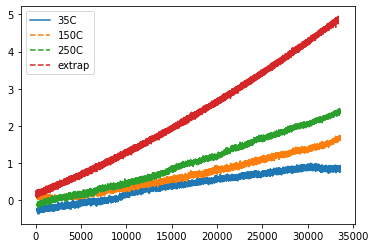

In [238]:
fig, (ax) = plt.subplots(1,1)
ax.plot(y[:,0],Z[:,0], '-', label='35C') # 
ax.plot(y[:,1],Z[:,1], '--', label='150C')
ax.plot(y[:,2],Z[:,2], '--', label='250C')
ax.plot(vals[0,:,1],vals[0,:,2], '--', label='extrap')
ax.legend()
plt.show()

Create Force Vector for Desired Force

In [239]:
len_p = len(vals[0,:,1])
vals_force = force*np.ones(len_p,)
vals_temp = desired_temp*np.ones(len_p,)
out_val = np.vstack([vals[0,:,1],vals[0,:,2],vals_force,vals_temp])
print(out_val)

[[0.00000000e+00 1.95310000e-01 3.90620000e-01 ... 3.33661010e+04
  3.33662964e+04 3.33664917e+04]
 [2.11891196e-01 1.23106891e-01 1.59335932e-01 ... 4.84204090e+00
  4.88147153e+00 4.85767599e+00]
 [1.80000000e+03 1.80000000e+03 1.80000000e+03 ... 1.80000000e+03
  1.80000000e+03 1.80000000e+03]
 [7.73000000e+02 7.73000000e+02 7.73000000e+02 ... 7.73000000e+02
  7.73000000e+02 7.73000000e+02]]


Properly Format DataFrame and Save

In [240]:
# This is all just formatting to get everything in the form I use
dataframe = pd.DataFrame(out_val[:,:].swapaxes(0,1),columns=['Time', 'Crack Length', 'Force', 'Temperature'])
print(dataframe)

#dataframe.insert(3,'Force',force_arr)
#dataframe.rename(columns={0:'Temp'}, inplace=True)
#dataframe.rename(columns={1:'Timestep'}, inplace=True)
#dataframe.rename(columns={2:'Crack Length'}, inplace=True)
#dataframe = dataframe[['Timestep', 'Crack Length', 'Force','Temp']]
#save
if add_noise>0:
  dataframe.to_csv('./Predict/HeatTreated/{}N_HT_{}K_noise.csv'.format(force,desired_temp), index=False)
else:
  dataframe.to_csv('./Predict/HeatTreated/{}N_HT_{}K.csv'.format(force,desired_temp), index=False)

               Time  Crack Length   Force  Temperature
0           0.00000      0.211891  1800.0        773.0
1           0.19531      0.123107  1800.0        773.0
2           0.39062      0.159336  1800.0        773.0
3           0.58593      0.177139  1800.0        773.0
4           0.78124      0.141106  1800.0        773.0
...             ...           ...     ...          ...
122795  33365.71043      4.830775  1800.0        773.0
122796  33365.90574      4.887822  1800.0        773.0
122797  33366.10105      4.842041  1800.0        773.0
122798  33366.29636      4.881472  1800.0        773.0
122799  33366.49167      4.857676  1800.0        773.0

[122800 rows x 4 columns]
